# Use Case 3: Real-time monitoring of DNS anomalies for domain hijacking detection 

we will use **DNS logs** to identify unusual or suspicious DNS activity that may indicate domain hijacking.


## Approach:
1. **Load DNS Logs**: Load `dns` log files from the specified directory using `zat`.
2. **Feature Extraction**:
   - Analyze **DNS queries**, **query frequency**, and **IP resolutions**.
   - Detect unusual patterns, rare queries, or suspicious spikes in DNS requests.
3. **ML Algorithm**:
   - Use **Isolation Forest** for anomaly detection to identify rare or unusual DNS queries.
4. **Real-time Analysis**:
   - Monitor DNS logs and periodically analyze incoming data.
5. **Visualization**:
   - Display anomalies as bar charts, scatter plots, and time-based trends.



## Code Breakdown:

1. **Load DNS Logs**:
   - Reads DNS logs from `.log.gz` files using the `zat` library.

2. **Preprocessing**:
   - Extracts key fields:
     - `ts`: Timestamp
     - `id.orig_h`: Source IP
     - `id.resp_h`: Destination IP
     - `query`: DNS query
     - `qtype_name`: Query type (e.g., `A`, `AAAA`, `CNAME`)
   - Adds an "hour" column for hourly analysis.

3. **Feature Engineering**:
   - Counts the occurrences of each DNS query per hour.
   - Standardizes the count using `StandardScaler` for anomaly detection.

4. **Isolation Forest for Anomaly Detection**:
   - The **Isolation Forest** algorithm detects rare or unusual DNS queries.
   - Marks anomalous DNS queries based on their count.

5. **Visualization**:
   - **Histogram**: Shows the distribution of DNS query counts with anomalies highlighted.
   - **Scatter Plot**: Displays query counts over time, with anomalies marked.


## Dependencies:
Install required packages:
```bash
pip install zat scikit-learn pandas matplotlib seaborn
```

---

## Key Benefits:
1. **Real-time Detection**:
   - Hourly monitoring enables near real-time anomaly detection.
2. **Domain Hijacking Indicators**:
   - Anomalous or rare DNS queries can signify suspicious domains.
3. **Scalable**:
   - Handles large DNS logs efficiently.
4. **Visual Interpretability**:
   - Visualizations provide insights into DNS query behavior.



Loading DNS Logs...
Loading ../zeek/logs/2024-12-16/dns.09:07:55-09:11:59.log.gz...
Loading ../zeek/logs/2024-12-16/dns.09:12:00-09:18:38.log.gz...
Loading ../zeek/logs/2024-12-16/dns.09:18:39-09:41:25.log.gz...
Loading ../zeek/logs/2024-12-16/dns.09:41:26-09:56:16.log.gz...
Loading ../zeek/logs/2024-12-16/dns.09:56:17-10:00:00.log.gz...
Loading ../zeek/logs/2024-12-16/dns.10:00:00-11:00:00.log.gz...
Loading ../zeek/logs/2024-12-16/dns.11:00:00-06:50:48.log.gz...
Preprocessing DNS Logs...
Generating Features...
Detecting Anomalies...


/home/wasit/miniconda3/envs/data-science-cyber-security/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Anomalous DNS Queries Detected:
     hour                       query  count  scaled_count  anomaly
171    10  _companion-link._tcp.local    235      5.609696       -1
187    10          _rdlink._tcp.local    349      8.476364       -1
188    10     _sleep-proxy._udp.local    378      9.205604       -1
321    11          _rdlink._tcp.local    280      6.741275       -1
Visualizing Anomalies...


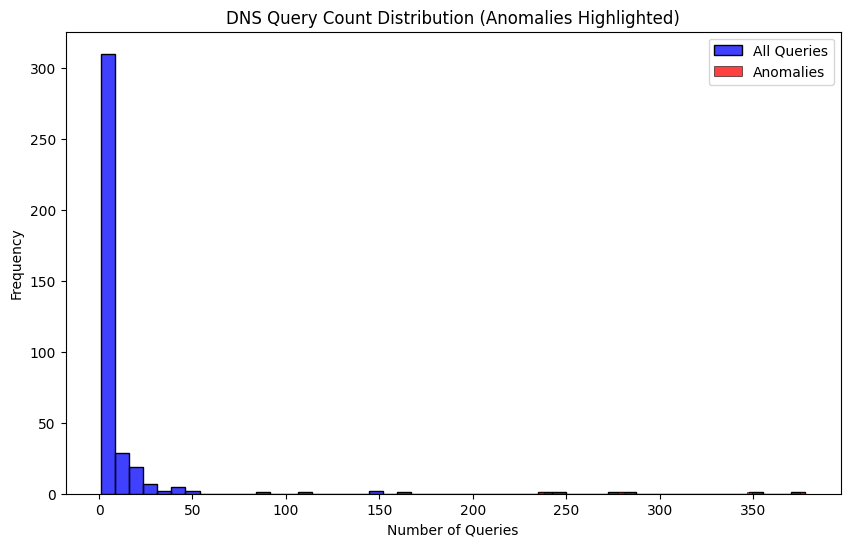

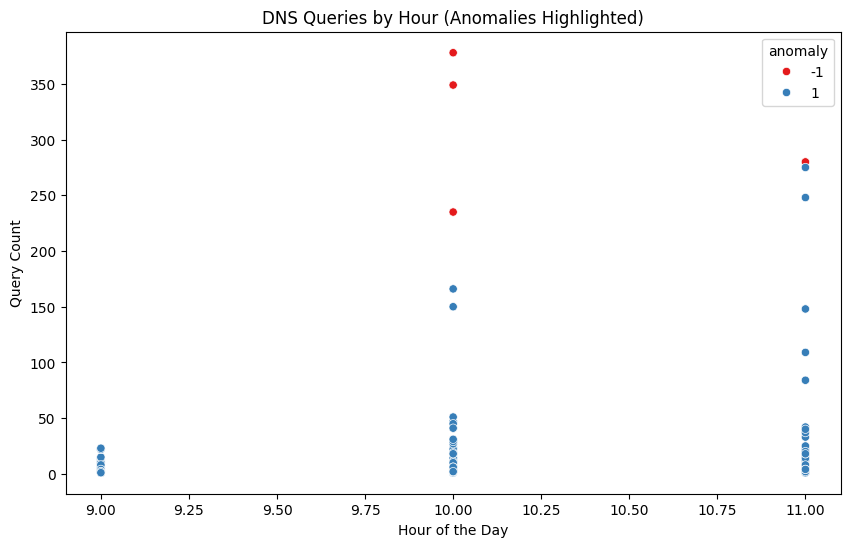

In [5]:
import gzip
import os
import pandas as pd
import numpy as np
import tempfile
from zat.log_to_dataframe import LogToDataFrame
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load DNS Logs
def load_dns_logs(log_directory, log_type="dns"):
    """Load DNS log files from a directory."""
    log_to_df = LogToDataFrame()
    dfs = []
    for file in sorted(os.listdir(log_directory)):
        if log_type in file and file.endswith(".gz"):
            file_path = os.path.join(log_directory, file)
            print(f"Loading {file_path}...")
            with gzip.open(file_path, "rb") as gzipped_file:
                with tempfile.NamedTemporaryFile(mode="wb", delete=False) as temp_file:
                    temp_file.write(gzipped_file.read())
                    uncompressed_path = temp_file.name
            df = log_to_df.create_dataframe(uncompressed_path).reset_index()
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Step 2: Preprocess DNS Logs
def preprocess_dns_logs(df):
    """Extract and preprocess features from DNS logs."""
    # Extract only necessary columns
    df = df[["ts", "id.orig_h", "id.resp_h", "query", "qtype_name"]].dropna()
    df["ts"] = pd.to_datetime(df["ts"])
    df["hour"] = df["ts"].dt.hour  # Add an hour column for hourly monitoring
    return df

# Step 3: Feature Engineering for DNS
def feature_engineering(df):
    """Generate DNS query counts and prepare for anomaly detection."""
    # Count DNS queries per hour per query type
    query_counts = df.groupby(["hour", "query"]).size().reset_index(name="count")
    
    # Standardize the count feature for anomaly detection
    scaler = StandardScaler()
    query_counts["scaled_count"] = scaler.fit_transform(query_counts[["count"]])
    
    return query_counts

# Step 4: Detect Anomalies with Isolation Forest
def detect_anomalies(query_counts):
    """Apply Isolation Forest to detect anomalies."""
    model = IsolationForest(contamination=0.01, random_state=42)
    query_counts["anomaly"] = model.fit_predict(query_counts[["scaled_count"]])
    
    # Mark anomalies
    anomalies = query_counts[query_counts["anomaly"] == -1]
    print("Anomalous DNS Queries Detected:")
    print(anomalies)
    return anomalies

# Step 5: Visualize DNS Anomalies
def visualize_dns_anomalies(query_counts, anomalies):
    """Visualize DNS anomalies using plots."""
    # Plot all DNS queries
    plt.figure(figsize=(10, 6))
    sns.histplot(query_counts["count"], bins=50, color="blue", label="All Queries")
    sns.histplot(anomalies["count"], bins=50, color="red", label="Anomalies")
    plt.title("DNS Query Count Distribution (Anomalies Highlighted)")
    plt.xlabel("Number of Queries")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Scatter plot for anomalies
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=query_counts, x="hour", y="count", hue="anomaly", palette="Set1")
    plt.title("DNS Queries by Hour (Anomalies Highlighted)")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Query Count")
    plt.show()

# Main Function for Real-Time DNS Anomaly Detection

log_directory = "../zeek/logs/2024-12-16"

# Step 1: Load DNS Logs
print("Loading DNS Logs...")
dns_df = load_dns_logs(log_directory)

# Step 2: Preprocess DNS Logs
print("Preprocessing DNS Logs...")
preprocessed_df = preprocess_dns_logs(dns_df)

# Step 3: Feature Engineering
print("Generating Features...")
query_counts = feature_engineering(preprocessed_df)

# Step 4: Detect Anomalies
print("Detecting Anomalies...")
anomalies = detect_anomalies(query_counts)

# Step 5: Visualize Anomalies
print("Visualizing Anomalies...")
visualize_dns_anomalies(query_counts, anomalies)

